In [0]:
import os
from fastai.text import *

In [20]:
os.environ['KAGGLE_USERNAME'] = "yonigottesman" # username from the json file 
os.environ['KAGGLE_KEY'] = "4b38ea3d9a7d2a9ee47010dc9650dd7d" # key from the json file 

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip '*.csv.zip'

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_labels.csv.zip
  inflating: test_labels.csv         

4 archives were successfully processed.


In [0]:
path = Path('/content/')
bs=48
data_lm = (TextList
           .from_csv(path, 'test.csv', cols='comment_text')
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch())
           #Finally we convert to a DataBunch

In [0]:
#data_lm.show_batch()
#data_lm.vocab.stoi


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [0]:
#learn.model

In [24]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.134400,3.853425,0.324891,08:46


In [25]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.688894,3.560594,0.364686,09:51


In [26]:
learn.predict('This is a review about', n_words=10)

'This is a review about Synagogues and Wikipedia . xxbos : :'

In [0]:
learn.save_encoder('ft_enc')

In [0]:
path = Path('/content/')
test = pd.read_csv(path/"test.csv")
test_datalist = TextList.from_df(test, cols='comment_text')

data_clas = (TextList.from_csv(path, 'train.csv', cols='comment_text', vocab=data_lm.vocab)
                .split_by_rand_pct(valid_pct=0.1)
                .label_from_df(cols=['toxic', 'severe_toxic','obscene', 'threat', 'insult', 'identity_hate'], label_cls=MultiCategoryList, one_hot=True)
                .add_test(test_datalist)
                .databunch())

In [29]:
data_clas.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
"xxbos xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist xxup cunt ! xxup fuck xxup you , xxup you xxup atheist",toxic;severe_toxic;obscene;insult
xxbos xxmaj user : xxup xxunk is a homo like mitt romney is . \n \n xxmaj user : xxup xxunk is a homo like mitt romney is . \n xxmaj user : xxup xxunk is a homo like mitt romney is . \n xxmaj user : xxmaj xxunk is a homo like mitt romney is . \n xxmaj user : xxmaj xxunk is a homo,toxic
"xxbos "" \n \n xxmaj history snapshots \n xxmaj here follow snapshots of the edit history related to merge of the articles xxmaj gaius xxmaj xxunk xxmaj xxunk and xxmaj gaius xxmaj xxunk xxmaj xxunk ( disambiguation ) . \n \n xxmaj pre - merge history of xxmaj gaius xxmaj xxunk xxmaj xxunk \n \n xxunk , 25 xxmaj october 2008 xxunk m ( xxunk bytes",
"xxbos "" \n \n xxup black xxup xxunk xxup murder xxup is xxup not ' xxup melodic xxup death xxup metal ' xxrep 29 ! xxup they xxup are xxup deathcore xxup pussies xxrep 17 ! \n \n xxmaj black xxmaj xxunk xxmaj murder xxup is xxup not xxmaj melodic xxmaj death xxmaj metal . xxmaj they are the xxunk band from that genre . xxmaj black xxmaj",toxic;obscene;insult


In [30]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types of accidents " " xxup -i think the references may need tidying so that they are all in the exact same format ie date format etc . i can do that later on , if no - one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know . 
 
  xxmaj there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up . xxmaj it 's listed in the relevant form eg xxmaj wikipedia : xxmaj xxunk 

In [31]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60000, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(60000, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


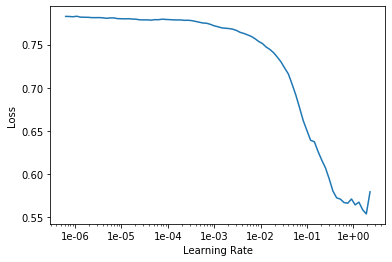

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.078201,0.065163,03:29


In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.054802,0.046580,04:07


In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.048859,0.119305,07:47


In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.040371,0.049013,08:38
1,0.037403,0.039993,07:19


In [0]:
preds, target = learn.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_df = pd.read_csv('/content/sample_submission.csv')
sample_df[list_classes] = labels
sample_df.to_csv('submission.csv', index=False)

In [40]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f '/content/submission.csv' -m "ulmfit"

100% 21.4M/21.4M [00:04<00:00, 4.65MB/s]
Successfully submitted to Toxic Comment Classification Challenge